In [2]:
import pandas as pd
import numpy as np
import os
import glob
import tempfile

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import col, explode, split, sum as spark_sum, countDistinct, collect_list, to_timestamp, lit, round
from pyspark.sql.types import StructType, StructField, StringType, LongType, BooleanType, DoubleType,ArrayType

import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import json
import time
import re
from time import sleep

import spacy  
from spacy.matcher import Matcher  
from collections import Counter  
from wordcloud import WordCloud  
import matplotlib.pyplot as plt 

pyspark.__version__

'3.5.0'

In [2]:
spark = SparkSession.builder.config('spark.ui.port', 64053).appName("project1").getOrCreate()
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/20 15:07:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


DataFrame[key: string, value: string]

In [3]:
# 加载Spacy英文模型  
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])  
  
# 创建一个Matcher对象  
matcher = Matcher(nlp.vocab)  
  
# 定义名词性短语的规则，这里我们使用名词短语的结构，例如名词短语可能是一个名词后跟一个或多个形容词或名词  
# 注意：这个规则很基础，可能无法捕获所有名词短语，你可以根据需要添加更多复杂的规则  
# 定义模式
pattern = [{'POS': {'IN': ['ADJ', 'NOUN']}, 'OP':'+'}, {'POS': 'NOUN'}]

# 添加模式到匹配器
matcher.add("NounPhrase", [pattern])

In [5]:
df = pd.DataFrame({'word':[]})

In [6]:
empty_pattern = r'^[ \n]*$' # 只包含空格和换行
rabbish_lines = ['Want to start a startup? Get funded by Y Combinator .', 'Like to build things? Try Hacker News .']# 出现多次，似乎是广告信息
path = "./paul_articles/General and Surprising.txt"
months = r'(January|February|March|April|May|June|July|August|September|October|November|December)'
year = r'\d{4}'
date_pattern = r'{} {}'.format(months, year)

In [8]:
# 输入的文本
files = os.listdir('./paul_articles/')
files.remove('Chapter 1 of Ansi Common Lisp.txt')
files.remove('Chapter 2 of Ansi Common Lisp.txt')
files.sort()
if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')

empty_pattern = r'^[ \n]*$' # 只包含空格和换行
rabbish_lines = ['Want to start a startup? Get funded by Y Combinator .', 'Like to build things? Try Hacker News .']# 出现多次，似乎是广告信息
i=1
for file in files:
    text = ""
    path = f'./paul_articles/{file}'
    with open(path, 'r', encoding='utf-8') as f:
        title = f.readline()
        date = f.readline()
        if re.match(date_pattern, date) or (date.strip() in rabbish_lines):#判断是否为日期或垃圾信息，是则跳过
            ph = f.readline()
        else:
            ph = date

        while ph != '':
            if not re.match(empty_pattern, ph): #判断为非空行
                text += ph
            ph = f.readline()

    # 处理文本  
    doc = nlp(text)  
    matches = matcher(doc)  

    # 提取名词短语并计数  
    noun_phrases = []  
    for match_id, start, end in matches:  
        span = doc[start:end]  
        noun_phrase = ' '.join([token.text for token in span]).strip()
        noun_phrases.append(noun_phrase)  
        
        # 创建要添加的新记录  
    new_record = pd.DataFrame({'word': noun_phrases})  

    # 使用.append()方法添加记录  
    df = pd.concat([df, new_record], ignore_index=True)
    
    print(f'{i} {file} select SUCCESSFULLY')
    i += 1

1 6,631,372.txt select SUCCESSFULLY
2 A Fundraising Survival Guide.txt select SUCCESSFULLY
3 A Local Revolution?.txt select SUCCESSFULLY
4 A New Venture Animal.txt select SUCCESSFULLY
5 A Plan for Spam.txt select SUCCESSFULLY
6 A Project of One's Own.txt select SUCCESSFULLY
7 A Student's Guide to Startups.txt select SUCCESSFULLY
8 A Unified Theory of VC Suckage.txt select SUCCESSFULLY
9 A Version 1.0.txt select SUCCESSFULLY
10 A Way to Detect Bias.txt select SUCCESSFULLY
11 A Word to the Resourceful.txt select SUCCESSFULLY
12 After Credentials.txt select SUCCESSFULLY
13 After the Ladder.txt select SUCCESSFULLY
14 Alien Truth.txt select SUCCESSFULLY
15 An Alternative Theory of Unions.txt select SUCCESSFULLY
16 An NFT That Saves Lives.txt select SUCCESSFULLY
17 Apple's Mistake.txt select SUCCESSFULLY
18 Are Software Patents Evil?.txt select SUCCESSFULLY
19 Be Good.txt select SUCCESSFULLY
20 Beating the Averages.txt select SUCCESSFULLY
21 Before the Startup.txt select SUCCESSFULLY
22 Bein

In [9]:
# 对word列进行计数，并按数量降序排序  
word_counts = df['word'].value_counts(sort=True, ascending=False)  
  
# 筛选出数量从大到小排位第40到50的单词及其数量  
# 注意：如果word_counts中的元素少于50个，你需要调整切片索引以避免IndexError  
selected_words = word_counts.iloc[39:50]
print(selected_words)

word
real world         35
startup hub        35
main reason        35
great things       34
few months         34
real work          32
long time          31
false positives    31
few people         30
own company        30
startup founder    29
Name: count, dtype: int64


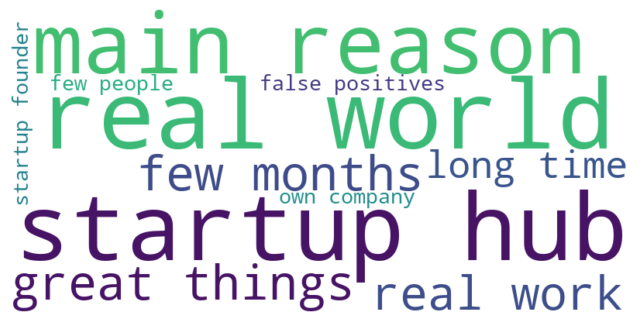

In [10]:
word_dict = selected_words.to_dict()
  
# 绘制词云  
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_dict)  
  
# 显示词云图  
plt.figure(figsize=(8, 8), facecolor=None)  
plt.imshow(wordcloud, interpolation='bilinear')  
plt.axis("off")  
plt.show()